# DSCI 572 Lab 4

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d

import matplotlib.pyplot as plt
%matplotlib inline

To install scikit-image, use

```
conda install -c conda-forge scikit-image
```

or 

```
pip install scikit-image
```

In [2]:
from skimage.color import rgb2gray
from skimage.transform import resize

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Instructions
rubric={mechanics:20}

Follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).

## Exercise 1: convolutions

For each of the filters given below, convolve the given image (or a different image of your choice) with the given filter and discuss why the results look the way they do. 

You can perform 2D convolutions using [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.convolve2d.html).

The suggested image size is around 100x100 pixels; if the image is too big, it will be hard to see the changes by eye using the very small filters given below. If you want to make an image smaller, try [scipy.misc.imresize](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imresize.html). This will be a lot faster than seam carving :)

Note: depending on your versions of various packages, you might get warnings when you run the code. It's OK.

In [5]:
def preprocess_image(filename):
    img = plt.imread(filename) # read in the image
    img = resize(img, (100,100), mode='reflect') # resize it if you want
    return rgb2gray(img) # make it grayscale

def show_conv(img, filt):

    plt.figure(figsize=(8,16))
    plt.subplot(1,2,1)
    
    plt.imshow(img, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title("original")
    I_filt = convolve2d(img,filt, boundary='symm', mode='same')

    I_filt = np.maximum(0, I_filt) # set negative values to 0, for visualization purposes
    I_filt = np.minimum(1, I_filt) # set values greater than 1 to 1, for visualization purposes
    plt.subplot(1,2,2)
    if np.sum(filt) == 0: # a trick to make the images easier to see, not part of the "math"
        plt.imshow(I_filt/np.max(I_filt), cmap='gray')
    else:
        plt.imshow(I_filt, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title("filtered")

    return I_filt

In [6]:
img = preprocess_image("milad_cropped.png")

**Example** (you don't need to do this one)

(1, 10)
[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


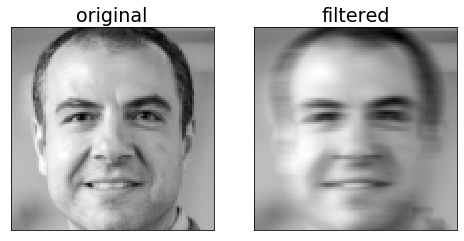

In [7]:
ft = 0.1*np.ones(10)[None]
print(ft.shape)
print(ft)

res = show_conv(img, ft)

**Example answer:** The filter is a horizontal bar all containing all $0.1$s. Therefore I would expect a blurring in the horizontal direction, meaning the _vertical_ edges get blurred (because these are the ones that change rapidly in the horizontal direction). This seems to be happening in the result. 

#### 1(a)
rubric={reasoning:5}

In [ ]:
ft = 0.1*np.ones(10)[:,None]
print(ft.shape)
print(ft)

res = show_conv(img, ft)

#### 1(b)
rubric={reasoning:5}

In [ ]:
ft = np.zeros((5,5))
ft[2,2] = 1
print(ft.shape)
print(ft)
res = show_conv(img, ft)

#### 1(c)
rubric={reasoning:5}

In [ ]:
ft = 0.01*np.ones((10,10))
print(ft.shape)
res = show_conv(img, ft)

#### 1(d)
rubric={reasoning:5}

In [ ]:
ft = -np.ones((3,3))/8
ft[1,1] = 1
print(ft.shape)
print(ft)
res6 = show_conv(img, ft)

#### (optional) 1(e)
rubric={reasoning:1}

Earlier in this course we talked about gradients and numerical differentiation. Think about part (d) above: does this have anything to do with the topics from earlier on? Can you relate these edge detection operations to "derivatives" or "gradients"?

Also, by the way, back in the seam carving lab of DSCI 512 we gave you a function that calculated the "energy" of an image, and we then looked for low energy seams. Here's the code we gave you:

In [ ]:
from scipy.ndimage.filters import convolve

def energy(image): 
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)

(There's no particular reason I switched from [`scipy.ndimage.filters.convolve`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html) to [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.convolve2d.html); they perform the same function for our purposes.) I thought you might enjoy looking back at this formerly mysterious code with your newfound knowledge. And it's also a bit of a hint: the seam carving energy function looked for "edges" or "changes" or ... derivatives! The above actually calculates the magnitude squared of the "gradient" at every point. The whole thing should make sense now as well -- when seam carving we wanted to remove pixels for which there wasn't much going on in the immediate vicinity.

## Exercise 2. Convolutional networks for MNIST

Sorry to continue with MNIST so long. It's just _THE_ classic data set for this stuff.


Below is some code that trains a convnet on MNIST. The code is adapted from the book [Deep Learning with Python](https://machinelearningmastery.com/deep-learning-with-python/) with permission from the author. 

In [ ]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
# take a subset of the data for speed
subset_size = 10000
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]

In [ ]:
# define a simple CNN model
def build_mnist_CNN():
    mnist_model = Sequential()
    mnist_model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
    mnist_model.add(Dropout(0.2))
    mnist_model.add(Flatten())
    mnist_model.add(Dense(128, activation='relu'))
    mnist_model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mnist_model

In [ ]:
mnist_model = build_mnist_cnn()

In [ ]:
# Fit the model
mnist_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256)
# Final evaluation of the model
scores = mnist_model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

#### 2(a)
rubric={reasoning:15}

Run the code above. How does it compare to your fully-connected ("Dense") neural net from lab 3? Discuss in 2-3 sentences. (Keep in mind that here we're only using a subset of the training data for speed.)

#### (optional) 2(b)
rubric={reasoning:1}

Let's assess what happens if we permute the rows of the images (both both training and testing). Below we permute the images, retrain the network, and re-evaluate the network. The accuracy is now lower. But we used the same data, just shuffled - can you explain why this operation hurt the accuracy?

In [ ]:
perm = np.random.permutation(X_train.shape[1])
perm

In [ ]:
n_plots = 3

for i in range(n_plots):
    ind = np.random.randint(X_train.shape[0])
    plt.subplot(2,2,1)
    plt.imshow(X_train[ind,...,0], cmap='gray');
    plt.title("Original");
    plt.subplot(2,2,2)
    plt.imshow(X_train[ind,perm,:,0], cmap='gray');
    plt.title("Permuted");
    plt.show()

Above: this is what a permuted training example looks like, with its rows shuffled.

In [ ]:
mnist_model_perm = build_mnist_CNN()

In [ ]:
# Fit the model
mnist_model_perm.fit(X_train[:,perm], y_train, validation_data=(X_test[:,perm], y_test), epochs=10, batch_size=256)
# Final evaluation of the model
scores = mnist_model_perm.evaluate(X_test[:,perm], y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

#### 2(c)
rubric={reasoning:30}

You will now deploy Keras/TensorFlow on the cloud using [Kaggle Kernels](https://www.kaggle.com/kernels). This will allow you to train on a GPU and assess the benefits of training neural networks on GPUs. Kaggle Kernels offers 30 hours of free GPU usage per account. This should be much more than adequate for this lab.

Note: last year we used [Google Colab](https://colab.research.google.com/) instead of Kaggle Kernels. That would have been fine for this exercise - they are roughly equivalent. But later in the lab, when we want to access a Kaggle dataset, Kaggle Kernels are way more convenient! (Furthermore... two years ago we used Amazon AWS and that was truly a huge hassle because they wouldn't recognize your @alumni.ubc.ca email addresses as "student email addresses".)

Follow these steps:

1. Save this Jupyter notebook so that it contains your latest work. Also push it to GitHub to be safe.
2. Go to https://www.kaggle.com/kernels
3. Make an account if you don't have one
4. Select New Notebook
7. Create
8. File->Upload notebook
9. Upload this notebook itself, lab4.ipynb, which you just saved.
5. On the right-hand side, go to Settings.
1. Make sure Internet is enabled.
1. Make sure GPU is enabled.

**SUGGESTION:** once you're done all your work on Kaggle (which means this exercise and the next one), you can download the notebook from Kaggle and overwrite your local version. That way any work you did on Kaggle won't be lost. (They allow working directly off a notebook on GitHub, but that feature won't work for us since we're using github.ubc.ca.)

Now, run the same MNIST experiment as above but on a Kaggle Kernel with the GPU active. 

1. How much faster is it (as a ratio) to run the exact same code on the GPU vs. your laptop? 
2. Notice the code above takes a subset of 10,000 training examples for speed. With the speed of the GPU, you should now use the full 60,000 training examples on AWS. Report your performance after 10 epochs when training on the full data set. How does it compare to the validation error you were able to get on your local machine (which presumably required using the smaller training set to run in reasonable time)? 
3. Again, compare to the fully connected network from lab 3.

## Exercise 3: Transfer learning

In this exercise we will work on the concept of _transfer learning_, in which we'll use a model trained on one task as a starting point for learning to perform another task. 

A natural question is, why is transfer learning helpful to us? Why can't we just train a model with the second task's objectives from the beginning? 
A key motivation is the difficulty in obtaining labeled data: ususally we need a whole lot of data in order to solve complex problems, and it can be hard to collect the data. (Another motivation is the time and effort -- both computational time and human time -- needed to train the original model. Someone did the work already, so we don't have to.)

In this exercise we'll apply transfer learning to fine-grained image classification. Here, the goal is to recognize different subclasses within a higher-level class. In our case, the higher level question could be, "Is this a dog?" and the fine-grained question is, "What breed of dog is this?"

We will use the [Kaggle dog breed identification](https://www.kaggle.com/c/dog-breed-identification/data) dataset. 
In the dataset, each dog image is labeled according to one of 120 breeds. We'll start with a pre-trained model that was already trained on a more high-level image classification task, namely the famous [ImageNet dataset](http://www.image-net.org/). You can see some sample ImageNet images [here](http://image-net.org/explore?wnid=n04516672).

We'll consider three approaches to the dog breed classification problem:

1. No transfer learning, just end-to-end training of a CNN directly for the dog breed classification task.
2. Use the pre-trained model as a feature extractor; then, add new layers in order to train it with the dog-breed dataset.
3. Some fine tuning of the weights of the pre-trained model (instead of freezing them all and only adding new layers, is in approach 2).

Attribution: In designing this exercise, we took some inspiration from [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). But I think our version is more interesting because the classes in our new task are not part of the original task.

### Preliminaries

I am assuming you already have your Kaggle Kernel set up as in the previous exercise, with the GPU and Internet enabled. Next, you will need to add the dataset to your Kaggle Kernel. (FYI: this is the part that is so much easier with Kaggle Kernels than Google Colab, where we had to install the Kaggle API on the Colab instance, set up key-based authentication, and then upload many GB worth of data from one cloud to the other, which turned out to work fine on ubcsecure wifi but not on eduroam wifi... lessons learned!)

- Go to https://www.kaggle.com/c/dog-breed-identification/rules, make sure you're signed in to Kaggle, and accept the competition rules.
- In your Kaggle Kernel, press "+ Add Data" at the upper-right.
- From the tabs at the top, select "Competition Data" (do not skip this step!)
- Search for "dog breed identification" in the search box. It should be the first result.
- Press "Add". Note: this will cause your kernel to restart.
- When asked if you want code to load the data, you can select "No" - I already have the code for you in this notebook, below.

### What you should do

As with the previous exercise, you should do this on the GPU on Kaggle. Your task for now is to read along and, **whenever there are code cells below, you should run them as you go along.** There will be some questions interspersed in the document, **which you should answer**.

Next, we take only the first 2000 samples from the original dataset. We want to simulate having only a small labeled dataset available to us, and see the effect of transfer learning.

In [ ]:
data = pd.read_csv('../input/dog-breed-identification/labels.csv')
data = data[:2000]
data['image_path'] = data.apply( lambda row: (os.path.join("../input/dog-breed-identification/train", row["id"] + ".jpg") ), axis=1)
data.head()

Above: you can see some of the breeds that we're predicting.

In [ ]:
target_labels = data['breed']
total_classes = len(set(target_labels))
print("number of dog breeds:", total_classes)

In [ ]:
# read images from the image directory. 
images = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in data['image_path'].values.tolist()])

In [ ]:
images.shape

Above: we have 2000 images, each of size $256 \times 256$ and with 3 colour channels.

In [ ]:
images = images.astype('float32')/255.0 

Above: it's very important to scale the images!

In [ ]:
plt.imshow(images[0]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);
plt.title("Breed = " + target_labels[0]);

Above: this is a sample image from the dog breed data set.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, target_labels, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)

#### 3(a)
rubric={reasoning:10}

Before we start, do some EDA to assess whether there is serious class imbalance in the training data. What training accuracy would you get with `DummyClassifier`? Briefly discuss your results.

#### 3(b)
rubric={reasoning:5}

How many training examples do we have per breed of dog, roughly? In the context of other classification tasks we've done in MDS, do you consider this to be a lot or a little?

Next, we do the one-hot encoding.

In [ ]:
Y_train = pd.get_dummies(y_train.reset_index(drop=True)).values
Y_valid = pd.get_dummies(y_valid.reset_index(drop=True)).values

print(Y_train.shape)
print(Y_valid.shape)

# Note: it would be better to use keras.utils.to_categorical, or something else like that,
# just in case one of the classes is absent in one of the two sets.
# But this works for now.

### Approach 1

Now, we try Approach 1, which is training an end-to-end CNN on the dog breed classification task.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(total_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

# FYI: it's often a good idea to save your weights after training or during training.
# But you don't have to here.
# model.save_weights('my_conv_net.h5')  

#### 3(c)
rubric={reasoning:1}

What do you think of the results? Are you impressed? 

### Approach 2

Here we load a pre-trained model and add some layers on top. The syntax is not what you're used to - that's OK, don't worry about it.

In [ ]:
# Get the InceptionV3 model trained on the ImageNet data set
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

Note the `include_top=False`. This throws away the last layer. It wasn't useful to us anyway. ImageNet has 1000 classes, but we're not interested in those classes. Another way to think of it is that the original model is a crazy feature extractor plus logistic regression for the 1000 ImageNet classes. We are using the feature extractor and discarding the logistic regression part.

In [ ]:
top_block = base_inception.output
top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(total_classes, activation='softmax')(top_block) # add another Dense layer

model_transfer = Model(inputs=base_inception.input, outputs=predictions)

Above: the syntax is not what you're used to - that's OK, don't worry about it.  If you want to know more, see [this documentation](https://keras.io/models/model/). However, at a high level we're grabbing the base model, doing some pooling, and then adding two new dense layers at the top.

In [ ]:
for layer in base_inception.layers:
    layer.trainable = False

Above: this is a key step. We "freeze" the layers of the base model, so that only our two new Dense layers at the top are trainable. That means we only update the weights in the new top layers - all the other weights (the ones from the base model) are fixed ("frozen") during training.

In [ ]:
model_transfer.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model_transfer.summary() # run me if you dare

Above: that's a lot of layers!

In [ ]:
history = model_transfer.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10)

#### 3(d)
rubric={reasoning:1}

How does this result compare to the "from scratch" CNN?

### Approach 3

Below, we un-freeze the last "15" layers, which is really only the last one or two layers, since the list of Keras layer objects doesn't really correspond to our idea of a layer (see `model.summary()`).

In [ ]:
for i, layer in enumerate(reversed(model_transfer.layers)):
    layer.trainable = True
#     print(layer)
    if i > 15:
        break

# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
# fine-tune the unfrozen layers
history = model_transfer.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10)

#### (optional) 3(e)
rubric={reasoning:1}

Un-freezing some of the layers seems to have a small effect here. Was it actually useful at all, or could we have achieved the same results by just training our top layers for more epochs?

#### 3(f)
rubric={reasoning:5}

In Lab 3 we noticed that unlike scikit-learn's `fit`, Keras's `fit` doesn't re-initialize the weights, but rather continues on from where you were. In the above code, we benefitted from this. Briefly describe how/why this behaviour was useful to us.

#### 3(g)
rubric={reasoning:10}

Brainstorm 3 other applications of this type of transfer learning, where you use a pre-trained network plus some modifications. In each case, what is the original task and what is the new task? (It's OK if you don't actually have access to a pre-trained network to do the original task; we're just brainstorming here.)

#### (optional) 3(h)
rubric={reasoning:3}

There are two perspectives on what we did in Approach 2: one is that we froze most of the layers and just fine-tuned the last layers. The other perspective is that we used a pre-trained feature extractor and then just used a simple model on top. In the above we added 2 layers on top, but if we added just one layer on top then it would just be a softmax logistic regression. Following this second perspective, can you get reasonable results by chaining together the feature extractor and a multi-class scikit-learn `LogisticRegression`? Perhaps this would be a good use case for a scikit-learn `Pipeline`? 

WARNING: I have not tried this myself, so there is a chance things will go wrong. If you get something to work, please let me know - I'm curious!

(You are now done with your Kaggle Kernel. If you were editing the file there, you should download it to your local machine before closing the Kaggle Kernel!)

## Exercise 4: Pondering


#### 4(a) 
rubric={reasoning:10}

When we previously worked on the handwritten digits dataset, we did something quite silly: we "flattened" images into vectors; for example $28\times 28$ MNIST images became vectors of length $28\times 28 = 784$. This is arguably insane! One reason it's insane is that we were completely discarding the "spatial information" contained in the image and just pretended we had 784 different features, whereas convnets preserve the 2D structure and take 2D convolutions. But there is another, related reason it's a bad idea to just flatten the images... what would go wrong if we tried to use fully connected nets on larger images, like $1000 \times 1000$ pixels?

#### 4(b)
rubric={reasoning:10}

For each of the following, would increasing this quantity typically increase, decrease, or have no effect on the number of parameters of the model? 

1. Dropout probability, e.g. `0.2`
2. Filter size, e.g. `(5,5)`
3. Number of filters, e.g. `32`

#### 4(c)
rubric={reasoning:10}

For each of the following, would increasing this quantity typically increase, decrease, or have no effect on the training error? No need to explain. 

1. Dropout probability, e.g. `0.2`
2. Filter size, e.g. `(5,5)`
3. Number of filter, e.g. `32`

#### 4(d)
rubric={reasoning:15}

What are the pros/cons of neural nets, vs. approaches previously learned (for both regression and classification)? Choose one method from a previous course (561, 571, 573) and compare it with what you've done in deep learning. Write a paragraph summarizing the results.

-----------------

All the rest are optional; if you want to be done, you're done!


#### (optional) 4(e) 
rubric={reasoning:1}

The code below shows that the MNIST model from Exercise 2 has 592,074 parameters. Explain where this number comes from by going layer by layer and accounting for all the parameters.

In [ ]:
mnist_model.summary()

#### (optional) 4(f)
rubric={reasoning:1}

Consider this CNN architecture:

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Now, we remove (comment out) pooling from the _first_ convolutional layer:

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Why does this change increase the number of parameters in the 3rd (Dense) layer, but not in the 2nd (Conv2D) layer?

#### (optional) 4(g) 
rubric={reasoning:1}

In the code above, the data is transformed to `float32` type. In lecture we discussed floating point representations. The main advantage of using 32-bit floating point numbers (versus 64-bit) is computational speed, but there's a disadvantage in terms of accuracy. Think about dropout and what it does/accomplishes. Did thinking about dropout alleviate your concerns about the potential pitfalls of using a smaller floating point represntation? Briefly discuss.

#### (optional) 4(h)
rubric={reasoning:1}

If you had access to 1000 GPUs, do you think you could get 1000x performance? If not, why? What are the limitations/bottlenecks?

## (optional) Exercise 5: setting priorities and time-management skills
rubric={reasoning:100}

_Rationale: admission into the MDS program is very competitive. This is great for me, because I enjoy working with such motivated and talented individuals. However, I conjecture that this same admissions process may also select for people with unrealistically high expectations of themselves. For example, I have noticed some students feel they must do all the optional questions even if they aren't particularly interested in the topic or don't really have the time to do them. If that sounds like you, this optional exercise was created for you! My hope is that none of you attempts, let alone completes, this silly exercise. In skipping it, you will need to forego the 100 bonus points.$^*$ I hope that by doing so, you will feel that it's perfectly fine to triage and skip certain lab questions: nothing bad happens! I believe this skill --- or perhaps you could call it a mindset --- will be extremely important for your success and wellbeing in the long-term. Doing everything perfectly is simply not possible forever, and when that time comes, it is important that you can set priorities. I have seen many people be ineffective at their jobs because they cannot skip the unimportant things. And now, the task..._

Do the following before the lab deadline:

- 400 push-ups
- 300 sit-ups
- recite the alphabet backwards 200 times
- memorize the names of 100 countries
- ask someone the following question: "What is $\int_1^\text{cabin} \frac{1}{x}\text{d}x$?"

You must include, with your submission, incontrovertible evidence that you did each of these things. Your word of honour will not be sufficient. 

$^*$_Also, please note that all lab grades in MDS are capped at 100%. That is, you can increase your grade up to 100% with optional questions, but not beyond 100%._

#### (optional) 5(b)
rubric={reasoning:1}

If you completed the first part of this exercise, write a brief reflection in 2-3 sentences. What did you learn about setting priorities and time-management skills?